In [1]:
import numpy as np
import time
import generalized_genSim_shorten_time_HMM as ggsdHMM
import numpy as np
import curve_fitting as cf
import matplotlib.pyplot as plt
#import matplotlib.colors as colors
#import matplotlib.cm as cmx
from scipy import optimize, stats
import bluepyopt as bpop
import bluepyopt.deapext.algorithms as algo
import vclamp_evaluator_HMMtoHH as vcl_ev
import pickle
import time
from deap import tools
#from deap import base, creator
import multiprocessing
#import eval_helper as eh
#import scoring_functions_relative as sf
#import curve_fitting as cf
import generalized_genSim_shorten_time as ggsd
import eval_helper_na12mut8st as ehn

Reached import hoc
Reached import neuron.hoc


In [7]:
evaluator = vcl_ev.Vclamp_evaluator_HMM('./csv_files/params_na12mut8st_mod.csv', 'Basis', 'na12mut8st', 'na12mut', objective_names=['act', 'inact', 'tau0', 'peak_amp'])


#evaluator = vcl_ev.Vclamp_evaluator_HMM('./param_stats_narrow.csv', 'A427D', 'na', objective_names=['v_half_act', 'gv_slope', 'v_half_ssi', 'ssi_slope'])

In [8]:
evaluator.wild_data



{'v_half_act': -19.438432175828535,
 'gv_slope': 6.1618554048712015,
 'v_half_ssi': -44.72164146029349,
 'ssi_slope': 7.055442056187008,
 'tau_fast': 0.8927258721940866,
 'tau_slow': 1.1909104890546904,
 'percent_fast': 0.002371458641170018,
 'tau0': 0.4231792451831216,
 'peak_amp': -0.0008489542350525562}

In [9]:
gen_counter = 0
best_indvs = []
cp_freq = 1
old_update = algo._update_history_and_hof
def my_update(halloffame, history, population):
    global gen_counter,cp_freq
    if halloffame is not None:
        halloffame.update(population)
    
    if halloffame:
        best_indvs.append(halloffame[0])
    gen_counter = gen_counter+1
    print("Current generation: ", gen_counter)
    if gen_counter%cp_freq == 0:
        fn = '.pkl'
        save_logs(fn,best_indvs,population)

def my_record_stats(stats, logbook, gen, population, invalid_count):
    '''Update the statistics with the new population'''
    record = stats.compile(population) if stats is not None else {}
    logbook.record(gen=gen, nevals=invalid_count, **record)
    print('log: \n', logbook, '\n')
    output = open("log.pkl", 'wb')
    pickle.dump(logbook, output)
    output.close()

def save_logs(fn, best_indvs, hof):
    output = open("indv"+fn, 'wb')
    pickle.dump(best_indvs, output)
    output.close()
    output = open("hof"+fn, 'wb')
    pickle.dump(hof, output)


In [10]:
#hof = tools.HallOfFame(1, similar=np.array_equal)
hof = tools.ParetoFront()
algo._update_history_and_hof = my_update
algo._record_stats = my_record_stats
pool = multiprocessing.Pool(processes=64)
deap_opt = bpop.optimisations.DEAPOptimisation(evaluator, offspring_size=100, hof = hof, map_function=pool.map)  # CHANGE offspring_size

cp_file = './cp.pkl'

Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate tau0 data
Couldn't generate ta

In [11]:
start_time = time.time()
pop, hof, log, hst = deap_opt.run(max_ngen=10, cp_filename=cp_file)  # CHANGE max_ngen
end_time = time.time()
print(end_time - start_time)

Current generation:  1
log: 
 gen	nevals	avg   	std   	min    	max   
1  	100   	979174	139882	1.78477	999161 

Current generation:  2
log: 
 gen	nevals	avg   	std   	min    	max   
1  	100   	979174	139882	1.78477	999161
2  	100   	979174	139882	1.78477	999161 

Current generation:  3
log: 
 gen	nevals	avg   	std   	min    	max   
1  	100   	979174	139882	1.78477	999161
2  	100   	979174	139882	1.78477	999161
3  	100   	954194	207129	1.50165	999159 

Current generation:  4
log: 
 gen	nevals	avg   	std   	min    	max   
1  	100   	979174	139882	1.78477	999161
2  	100   	979174	139882	1.78477	999161
3  	100   	954194	207129	1.50165	999159
4  	100   	879258	324687	1.50165	999159 

Current generation:  5
log: 
 gen	nevals	avg   	std   	min    	max   
1  	100   	979174	139882	1.78477	999161
2  	100   	979174	139882	1.78477	999161
3  	100   	954194	207129	1.50165	999159
4  	100   	879258	324687	1.50165	999159
5  	100   	769350	420476	1.50165	999159 

Current generation:  6
log: 
 gen	nevals

In [12]:
print(log)

gen	nevals	avg   	std   	min    	max   
1  	100   	979174	139882	1.78477	999161
2  	100   	979174	139882	1.78477	999161
3  	100   	954194	207129	1.50165	999159
4  	100   	879258	324687	1.50165	999159
5  	100   	769350	420476	1.50165	999159
6  	100   	759359	426722	1.50165	999161
7  	100   	824304	379646	1.50165	999160
8  	100   	704406	455657	1.50165	999160
9  	100   	669435	469815	1.50165	999159
10 	100   	939207	237286	1.50165	999160


In [25]:
evaluator.evaluate_with_lists(best_indvs[-1])

[0.8274270046031251, 0.33574783033528377, 0.026039714451709748]

In [26]:
import eval_helper as eh
eh.change_params(best_indvs[-1], scaled=False, is_HMM=True)

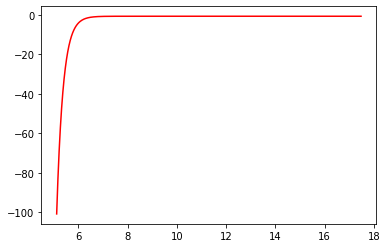

0.26181098792132385

In [27]:
ehn.find_tau0(make_plot=True)

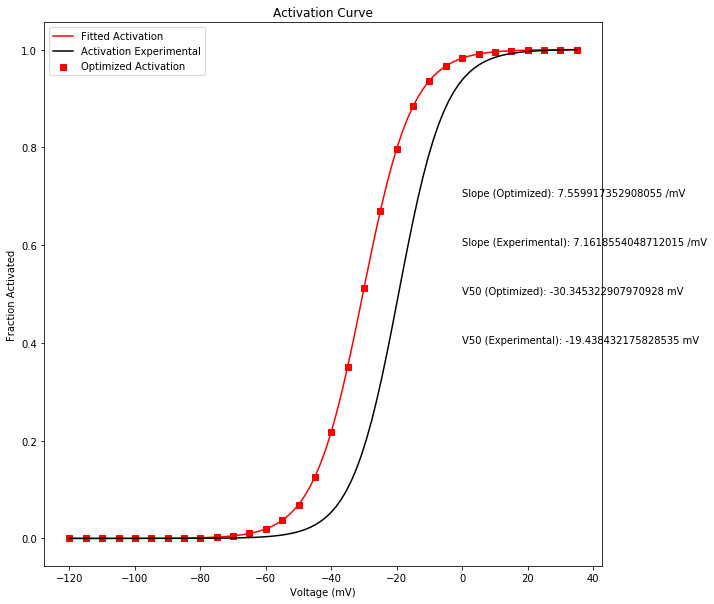

In [28]:
evaluator.plot_act(best_indvs[-1])

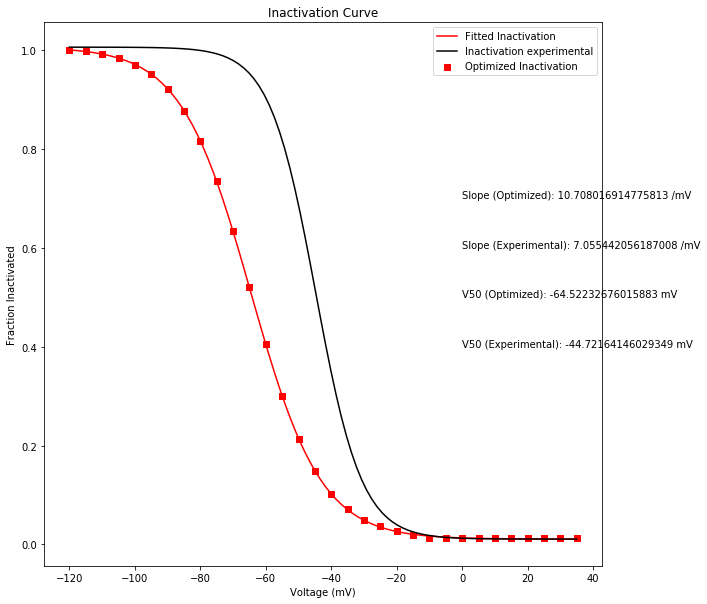

In [29]:
evaluator.plot_inact(best_indvs[-1])